# Anomaly Detection

This notebook shows some basic usage of CapyMOA for Anomaly Detection tasks.

Algorithms: `HalfSpaceTrees`, `Autoencoder` and `Online Isolation Forest`

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 29/07/2024**

## 1. Creating simple anomalous data with `sklearn`

* Generating a few examples and some simple anomalous data using `sklearn`

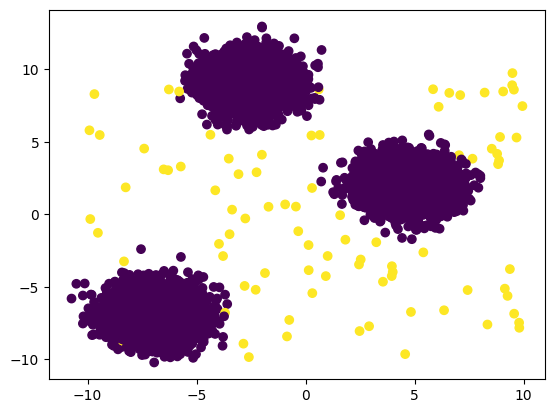

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from capymoa.stream import NumpyStream

# generate normal data points
n_samples = 10000
n_features = 2
n_clusters = 3
X, y = make_blobs(
    n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42
)

# generate anomalous data points
n_anomalies = 100  # the anomaly rate is 1%
anomalies = np.random.uniform(low=-10, high=10, size=(n_anomalies, n_features))

# combine the normal data points with anomalies
X = np.vstack([X, anomalies])
y = np.hstack([y, [1] * n_anomalies])  # Label anomalies with 1
y[:n_samples] = 0  # Label normal points with 0

# shuffle the data
idx = np.random.permutation(n_samples + n_anomalies)
X = X[idx]
y = y[idx]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

# create a NumpyStream from the combined dataset
feature_names = [f"feature_{i}" for i in range(n_features)]
target_name = "class"

## 2. Unsupervised Anomaly Detection for data streams

* Recent research has been focused on unsupervised anomaly detection for data streams, as it is often difficult to obtain labeled data for training.
* Instead of using evaluation functions, we first use a basic **test-then-train loop** from scratch to evaluate the model's performance.
* Please notice that lower scores indicate higher anomaly likelihood.

In [2]:
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import AnomalyDetectionEvaluator

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
learner = HalfSpaceTrees(stream_ad.get_schema())
evaluator = AnomalyDetectionEvaluator(stream_ad.get_schema())
while stream_ad.has_more_instances():
    instance = stream_ad.next_instance()
    score = learner.score_instance(instance)
    evaluator.update(instance.y_index, score)
    learner.train(instance)

auc = evaluator.auc()
print(f"AUC: {auc:.2f}")

AUC: 0.95


## 3. High-level evaluation functions

* CapyMOA provides `prequential_evaluation_anomaly` as a high level function to assess Anomaly Detectors


### 3.1 ```prequential_evaluation_anomaly```
In this example, we use the ```prequential_evaluation_anomaly``` function with ```plot_windowed_results``` to plot AUC for HalfSpaceTrees on the synthetic data stream

AUC: 0.9500215


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.979778,0.245731,0.063,0.001219,0.000000,0.011122,0.2293,1.0,-84.181818
1,2000.0,0.950367,0.179700,0.007,0.000000,0.979778,0.007049,0.0000,1.0,-109.333333
2,3000.0,0.960474,0.197694,0.011,0.000000,0.950367,0.011122,0.0000,1.0,-101.310345
3,4000.0,0.962883,0.173625,0.007,0.000000,0.960474,0.007049,0.0000,1.0,-109.333333
4,5000.0,0.964773,0.202764,0.013,0.000000,0.962883,0.013171,0.0000,1.0,-99.714286
5,6000.0,0.953784,0.214720,0.013,0.000000,0.964773,0.013171,0.0000,1.0,-94.516129
6,7000.0,0.955713,0.198651,0.009,0.000000,0.953784,0.009082,0.0000,1.0,-96.704225
7,8000.0,0.942093,0.183817,0.013,0.000000,0.955713,0.013171,0.0000,1.0,-93.000000
8,9000.0,0.936996,0.215112,0.008,0.000000,0.942093,0.008065,0.0000,1.0,-96.043478
9,10000.0,0.923891,0.205992,0.008,0.000000,0.936996,0.008065,0.0000,1.0,-98.200000


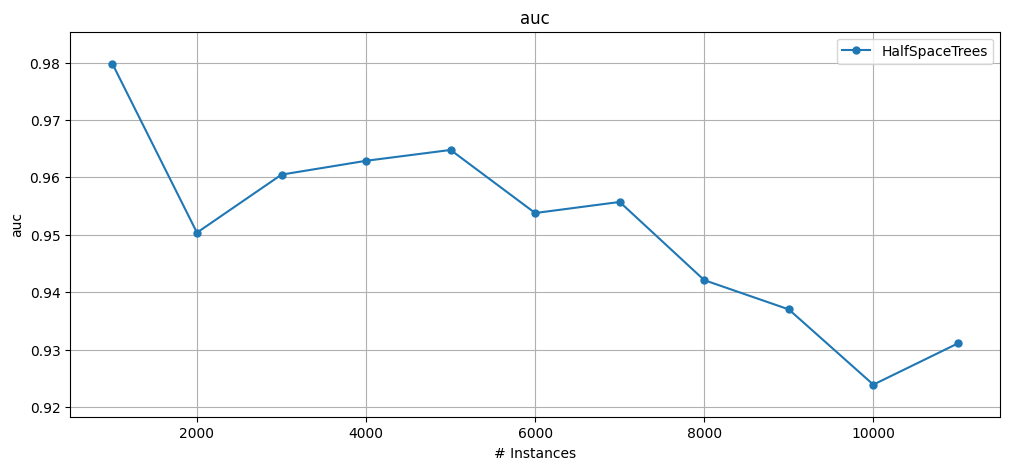

In [3]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
hst = HalfSpaceTrees(schema=stream_ad.get_schema())

results_hst = prequential_evaluation_anomaly(
    stream=stream_ad, learner=hst, window_size=1000
)

print(f"AUC: {results_hst.auc()}")
display(results_hst.windowed.metrics_per_window())
plot_windowed_results(results_hst, metric="auc", save_only=False)

## 3.2 Autoencoder

AUC: 0.4573365


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.319423,-0.076939,0.011,0.000000,0.000000,0.011122,0.000000,1.000000,-88.909091
1,2000.0,0.529852,-0.158113,0.007,0.000000,0.319423,0.007049,0.000000,1.000000,-109.333333
2,3000.0,0.425774,-0.099455,0.012,0.000022,0.529852,0.011122,0.031798,1.000000,-101.206897
3,4000.0,0.614084,-0.195348,0.008,0.000014,0.425774,0.007049,0.031734,1.000000,-109.222222
4,5000.0,0.524667,-0.174389,0.013,-0.001978,0.614084,0.013171,0.030582,0.923077,-99.714286
5,6000.0,0.407295,-0.128903,0.014,0.000026,0.524667,0.013171,0.031830,1.000000,-94.419355
6,7000.0,0.413051,-0.091194,0.010,0.000018,0.407295,0.009082,0.031766,1.000000,-96.605634
7,8000.0,0.490842,-0.174255,0.012,-0.002002,0.413051,0.013171,0.000000,0.923077,-93.095238
8,9000.0,0.506111,-0.181460,0.008,0.000000,0.490842,0.008065,0.000000,1.000000,-96.043478
9,10000.0,0.405494,-0.103295,0.008,0.000000,0.506111,0.008065,0.000000,1.000000,-98.200000


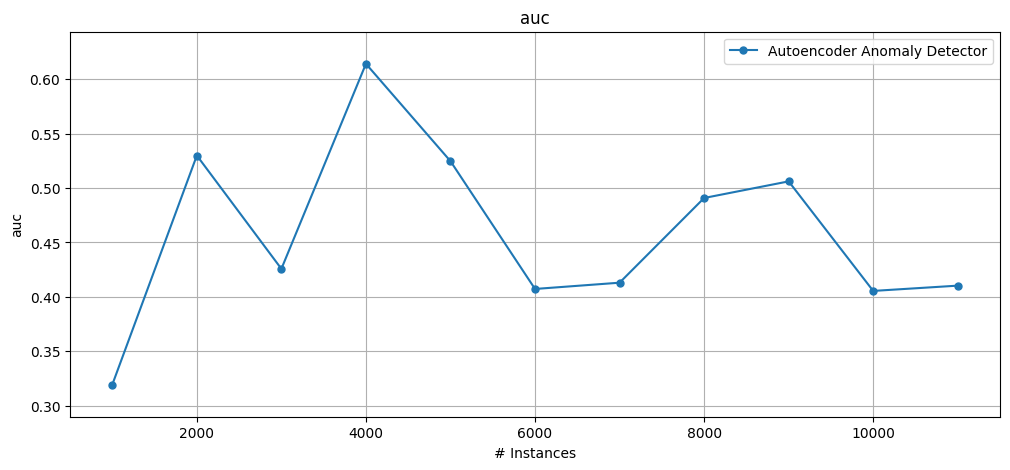

In [4]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import Autoencoder
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
ae = Autoencoder(schema=stream_ad.get_schema(), hidden_layer=1)

results_ae = prequential_evaluation_anomaly(
    stream=stream_ad, learner=ae, window_size=1000
)

print(f"AUC: {results_ae.auc()}")
display(results_ae.windowed.metrics_per_window())
plot_windowed_results(results_ae, metric="auc", save_only=False)

## 3.3 Online Isolation Forest

AUC: 0.2633305


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.616693,0.051133,0.052,0.000951,0.000000,0.011122,0.203608,1.000000,-85.181818
1,2000.0,0.280967,0.009284,0.027,-0.001742,0.616693,0.007049,0.134636,0.857143,-107.111111
2,3000.0,0.218265,0.011851,0.034,-0.003538,0.280967,0.011122,0.143813,0.818182,-98.931034
3,4000.0,0.137750,0.005062,0.028,-0.005818,0.218265,0.007049,0.117520,0.571429,-107.000000
4,5000.0,0.203647,0.007391,0.041,-0.007421,0.137750,0.013171,0.149819,0.692308,-96.857143
5,6000.0,0.208986,0.007555,0.028,-0.005643,0.203647,0.013171,0.118442,0.769231,-93.064516
6,7000.0,0.300538,0.010856,0.029,-0.003688,0.208986,0.009082,0.131402,0.777778,-94.732394
7,8000.0,0.151196,0.007418,0.044,-0.007361,0.300538,0.013171,0.156684,0.692308,-90.047619
8,9000.0,0.294166,0.014279,0.037,0.000482,0.151196,0.008065,0.170979,1.000000,-93.206522
9,10000.0,0.512664,0.016512,0.026,-0.001728,0.294166,0.008065,0.129457,0.875000,-96.400000


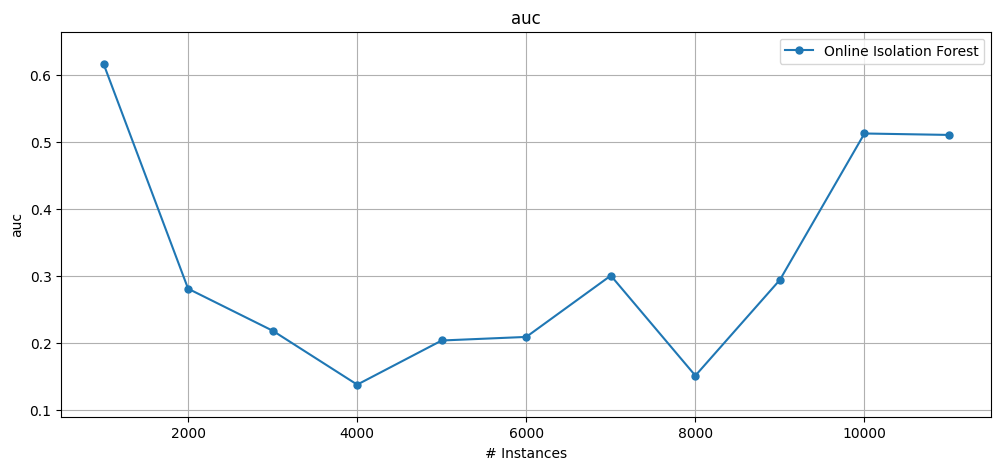

In [5]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
oif = OnlineIsolationForest(schema=stream_ad.get_schema(), num_trees=10)

results_oif = prequential_evaluation_anomaly(
    stream=stream_ad, learner=oif, window_size=1000
)

print(f"AUC: {results_oif.auc()}")
display(results_oif.windowed.metrics_per_window())
plot_windowed_results(results_oif, metric="auc", save_only=False)

## 4 Comparing algorithms

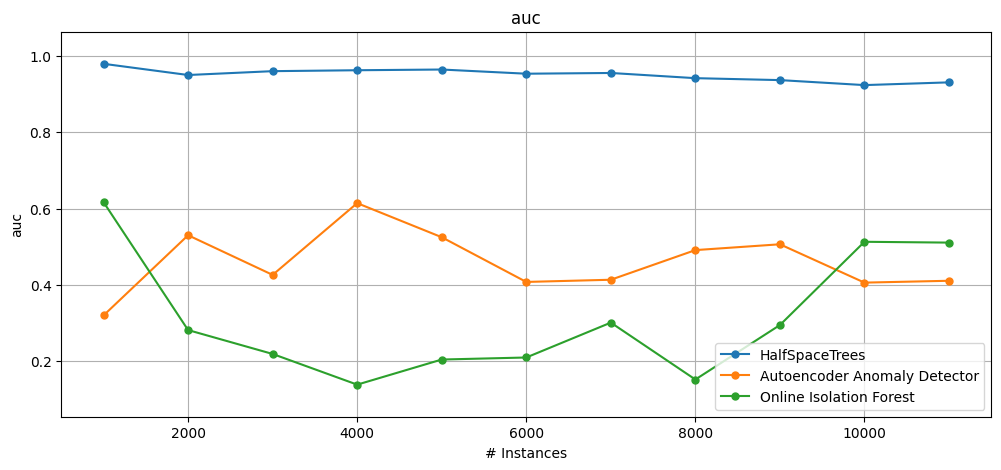

In [6]:
plot_windowed_results(
    results_hst, results_ae, results_oif, metric="auc", save_only=False
)